In [1]:
import glob
import os

import re
import PIL
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from keras.engine.saving import load_model
from other_models.metrics.scores import GlobalF1
from sklearn.metrics import f1_score

from other_models.img.processor import extract_data, extract_labels, read_img_file
from other_models.img.prediction import get_prediction_with_overlay, get_testing_prediction, \
    get_prediction_with_overlay_correctness, get_testing_prediction_overlay, get_prediction_concat
from other_models.models.data_augmentation import CenteredCropGenerator
%matplotlib inline

np.random.seed(2)

import time

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


In [2]:
# check if using cpu or gpu
from tensorflow.python.client import device_lib 


import tensorflow as tf
print(tf.__version__)


print(device_lib.list_local_devices())

2.0.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17473219037458420757
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9183368494782363417
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6236939823606394479
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3598712832
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1584895657827992156
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
# train
# history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#          validation_data = (X_val, Y_val), verbose = 2)

In [4]:
data_dir = '../data/training/'
train_data_filename = data_dir + 'images/'
train_labels_filename = data_dir + 'groundtruth/' 
test_data_filename = '../data/test_set_images/'
SAVED_MODEL_DIR = '../pretrained_cnn/models'

load existing model for resuming training or just use it for prediction directly, manually set epoch to 0 before training

In [5]:
# LOAD_MODEL_NAME = ''
LOAD_MODEL_NAME = f'{SAVED_MODEL_DIR}/custom_pad_28_29.hdf5'
# MODEL_NAME='unet'
MODEL_NAME='custom_pad_28_diag'
SAVE_TRAINED_MODEL = False
IS_SUBMISSION = False
# Extract it into numpy arrays.

PADDING = 28
CROP_SIZE = 16
IMAGE_SHAPE = (400, 400, 3)
image_generator = CenteredCropGenerator(PADDING, 
                                        (400, 400, 3), 
                                        (CROP_SIZE, CROP_SIZE), 
                                        horizontal_flip=True, 
                                        vertical_flip=True,
                                        rot90=True,
                                        color_change=0.2, # in % of actual pixel value
                                        rot_angle=45
                                        )

# inferred shape according to the desired padding
input_shape = image_generator.get_generated_shape()



In [6]:
if IS_SUBMISSION:
    TRAIN_SIZE = 1.0
    # data = extract_data(train_data_filename, range(1, 100 + 1), image_generator_padding=image_generator)
    # labels = np.array([read_img_file(train_labels_filename, i) for i in range(1, 100 + 1)])
    
    data = np.array([read_img_file(train_data_filename, i) for i in range(1, 100 + 1)])
    labels = np.array([read_img_file(train_labels_filename, i) for i in range(1, 100 + 1)])
else:
    TRAIN_SIZE = 0.85
    train_nb = int(100 * TRAIN_SIZE)
    
    # read full images without croping them used as input of the image generator
    x_train = np.array([read_img_file(train_data_filename, i) for i in range(1, train_nb + 1)])
    y_train = np.array([read_img_file(train_labels_filename, i) for i in range(1, train_nb + 1)])
    
    # validation set, croped images 
    x_test = extract_data(train_data_filename, range(train_nb + 1, 100 + 1), padding=PADDING)
    y_test = extract_labels(train_labels_filename, range(train_nb + 1, 100 + 1))

Finish loading all images
Finish loading all images


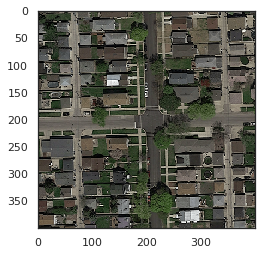

In [7]:
img = x_train[0]
plt.imshow(img)

In [8]:
type(img)

numpy.ndarray

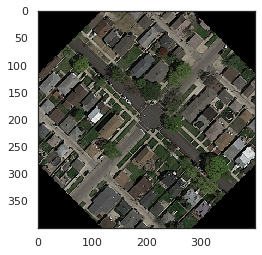

In [9]:
rotated = np.asarray(PIL.Image.fromarray(np.uint8(img * 255)).rotate(45)).astype('float32')/255.0

plt.imshow(rotated)

In [10]:
if IS_SUBMISSION:
    x_train = data
    y_train = labels
else:

    total_train_c0 = np.mean(y_train == [1, 0])
    total_train_c1 = np.mean(y_train == [0, 1])
    print(f'TRAIN class 0 (background) : {total_train_c0} and class 1 (road) :{total_train_c1}')
    
    total_test_c0 = np.mean(y_test == [1, 0])
    total_test_c1 = np.mean(y_test == [0, 1])
    print(f'VALIDATION class 0 (background) : {total_test_c0} and class 1 (road) :{total_test_c1}')
    
    # print(f"original size {len(labels)}")
    print(f"train size {len(y_train)}")
    print(f"validation size {len(y_test)}")

TRAIN class 0 (background) : 0.0 and class 1 (road) :0.0
VALIDATION class 0 (background) : 0.75392 and class 1 (road) :0.24608
train size 85
validation size 9375


/home/szhang/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/szhang/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Definition of custom shallow network

In [11]:
def get_custom_nn(input_shape):
    custom_model = Sequential()

    custom_model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', 
                     input_shape = input_shape))
    custom_model.add(LeakyReLU(alpha=0.1))
    custom_model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same'))
    custom_model.add(LeakyReLU(alpha=0.1))
    custom_model.add(MaxPool2D(pool_size=(2,2), padding='Same'))
    custom_model.add(Dropout(0.25))

    custom_model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same'))
    custom_model.add(LeakyReLU(alpha=0.1))
    custom_model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same'))
    custom_model.add(LeakyReLU(alpha=0.1))
    custom_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='Same'))
    custom_model.add(Dropout(0.25))

    custom_model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same'))
    custom_model.add(LeakyReLU(alpha=0.1))
    custom_model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same'))
    custom_model.add(LeakyReLU(alpha=0.1))
    custom_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='Same'))
    custom_model.add(Dropout(0.25))

    custom_model.add(Flatten())
    custom_model.add(Dense(256, activation = "relu"))
    custom_model.add(Dropout(0.5))
    custom_model.add(Dense(2, activation = "softmax"))

    return custom_model

For importing deep networks trained on imagenet dataset

In [12]:
def get_nn_model(nn_model, input_shape, freeze_n=0):
    backbone = nn_model(weights='imagenet', input_shape = input_shape, include_top = False)
    for layer in backbone.layers[:freeze_n]:
        layer.trainable = False
    model = Sequential()
    model.add(backbone)
    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    return model

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=3, 
                                                verbose=1, 
                                                factor=0.5, 
                                                epsilon=0.0001,
                                                min_lr=0)

/home/szhang/anaconda3/envs/py37/lib/python3.7/site-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [14]:
early_stop_callback = EarlyStopping(monitor='acc', min_delta=0.0001, patience=11, verbose=1, mode='auto')

In [15]:
if LOAD_MODEL_NAME:
    model = load_model(LOAD_MODEL_NAME)
else:

    model = get_custom_nn(input_shape)

    optimizer = Adam(0.001)
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["acc"])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 72, 72, 32)        2432      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        25632     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 36, 36, 64)       

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 72, 72, 32)        2432      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        25632     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 36, 36, 64)       

Callback for computing F1 score on global validation set, as f1 metric does not exist 

In [17]:
global_f1s = GlobalF1()

In [18]:
epochs = 40 # small dataset, so we can afford greater number of epochs
batch_size = 200 # small dataset, small batch_size

In [19]:
steps_per_epoch=x_train.shape[0]*10
print(f'steps per epoch {steps_per_epoch}')
a, b = next(iter(image_generator.generate_batches(x_train, y_train, batch_size=batch_size)))

steps per epoch 850


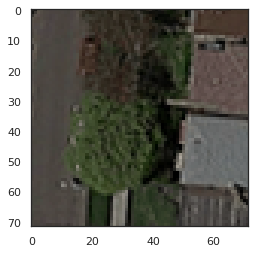

In [20]:
plt.imshow(a[1])

In [21]:
print(b[1])

[1. 0.]


In [22]:
# plt.imshow(x_test[0])

catch keyboard interrupt to not throw away the model that is being trained if run in a script
and set random seed before data model training for reproductibility purpose

In [23]:
np.random.seed(0)
begin = time.time()
try:

    if IS_SUBMISSION:
        history = model.fit_generator(image_generator.generate_batches(x_train, y_train, batch_size=batch_size),
                              epochs = epochs, 
                              verbose = 2, 
                              steps_per_epoch=steps_per_epoch, 
                              callbacks=[learning_rate_reduction, early_stop_callback])
    else:
        history = model.fit_generator(image_generator.generate_batches(x_train, y_train, batch_size=batch_size),
                      epochs = epochs, 
                      validation_data = (x_test, y_test),
                      verbose = 2, 
                      steps_per_epoch=steps_per_epoch, 
                      callbacks=[learning_rate_reduction, early_stop_callback, global_f1s])

except KeyboardInterrupt:
# Do not throw away the model in case the user stops the training process
    pass
end = time.time()
print(f"Total training time : {end - begin}")

Epoch 1/40
 - 269s - loss: 0.4419 - acc: 0.7872 - val_loss: 0.3799 - val_acc: 0.8284
F1 score on validation set 0.650293414475114
Epoch 2/40
 - 260s - loss: 0.2733 - acc: 0.8803 - val_loss: 0.3096 - val_acc: 0.8624
F1 score on validation set 0.7101123595505617
Epoch 3/40
 - 260s - loss: 0.2246 - acc: 0.9046 - val_loss: 0.2427 - val_acc: 0.8943
F1 score on validation set 0.7655547669742133
Epoch 4/40
 - 260s - loss: 0.1991 - acc: 0.9164 - val_loss: 0.2381 - val_acc: 0.8933
F1 score on validation set 0.7715851987208773
Epoch 5/40
 - 260s - loss: 0.1878 - acc: 0.9225 - val_loss: 0.2305 - val_acc: 0.9034
F1 score on validation set 0.7964959568733154
Epoch 6/40
 - 260s - loss: 0.1798 - acc: 0.9259 - val_loss: 0.2245 - val_acc: 0.9066
F1 score on validation set 0.7985280588776449
Epoch 7/40
 - 260s - loss: 0.1782 - acc: 0.9270 - val_loss: 0.2210 - val_acc: 0.9124
F1 score on validation set 0.8129414445203919
Epoch 8/40
 - 260s - loss: 0.1715 - acc: 0.9293 - val_loss: 0.2155 - val_acc: 0.9119

/home/szhang/anaconda3/envs/py37/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


<module 'time' (built-in)>
val acc :  0.9170106634497642


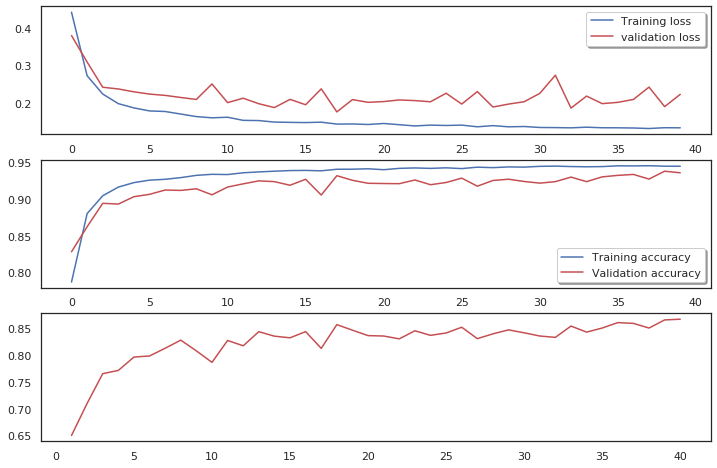

In [24]:
def print_history(history, f1s):
    print(time)
    fig, ax = plt.subplots(3,1, figsize=(12, 8))
    ax[0].plot(history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
    ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    print("val acc : ", np.mean(history.history['val_acc']))
    
    ax[2].plot(range(1, len(f1s) + 1), f1s, color='r',label="Validation F1 score")
    
if not IS_SUBMISSION:
    print_history(history, global_f1s.f1s)

save ENTIRE model (nn architecture, weights, state of optimizer)
with given prefix name appended with its version number, if conflict, try then next number for automation purpose

In [25]:
if SAVE_TRAINED_MODEL:
    def save_model(model: Model, name, directory="pretrained_cnn/models"):
        new_filename = f"{directory}/{name}_0.hdf5"
        files = glob.glob(f"{directory}/{name}*.hdf5")
        if new_filename in files:
            reg_num = re.compile("\d+")
            last_num = max([int(reg_num.findall(file)[0]) for file in files if reg_num.search(file)])
            next_num = last_num + 1
            new_filename = f"{directory}/{name}_{next_num}.hdf5"
    
        model.save(new_filename)
    save_model(model, MODEL_NAME, SAVED_MODEL_DIR)

In [26]:
if not IS_SUBMISSION :
    true_val_labels = np.argmax(y_test, axis = 1)
    pred_val_labels = np.argmax(model.predict(x_test), axis = 1)
    print(f1_score(true_val_labels, pred_val_labels))

0.8670648086706481


In [27]:
if not IS_SUBMISSION:
    TRAIN_SIZE = 0.9
    train_nb = int(100 * TRAIN_SIZE)
    # val_nb = 100 - train_nb
    x_test = extract_data(train_data_filename, range(train_nb + 1, 100 + 1), padding=PADDING)
    y_test = extract_labels(train_labels_filename, range(train_nb + 1, 100 + 1))
    # x_test = extract_data(train_data_filename, range(train_nb + 1, 100 + 1), image_generator_padding=image_generator)
    # y_test = extract_labels(train_labels_filename, range(train_nb + 1, 100 + 1))

Finish loading all images
Finish loading all images


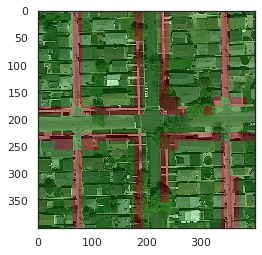

In [28]:
# check prediction correctness on one training picture

# pimg_train = get_prediction_concat(train_data_filename, 1, model)
pimg_train = get_prediction_with_overlay_correctness(train_data_filename, train_labels_filename, 1, model, padding=PADDING)
plt.imshow(pimg_train)

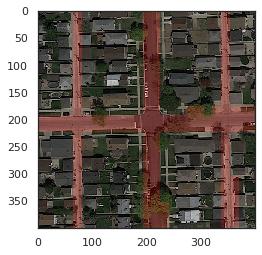

In [29]:
# training picture road prediction overlay
oimg = get_prediction_with_overlay(train_data_filename, 1, model, padding=PADDING)
plt.imshow(oimg)


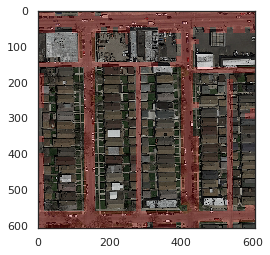

In [30]:
# test picture prediction overlay
pimg_test = get_testing_prediction_overlay(test_data_filename, 1, model, padding=PADDING)
plt.imshow(pimg_test)

In [31]:
prediction_training_dir = "../data/tf_tmp/predictions_training/"
prediction_testing_dir = "../data/tf_tmp/predictions_testing/"
prediction_testing_overlay_dir = "../data/tf_tmp/predictions_testing_overlay/"

In [32]:

if IS_SUBMISSION:
# if True:
    
    TRAINING_SIZE = 100
    
    print("Running prediction on training set")
    if not os.path.isdir(prediction_training_dir):
        os.mkdir(prediction_training_dir)
    for i in range(1, TRAINING_SIZE + 1):
        pimg = get_prediction_concat(train_data_filename, i, model, padding=PADDING)
        Image.fromarray(pimg).save(prediction_training_dir + "prediction_" + str(i) + ".png")
        # oimg = get_prediction_with_overlay(train_data_filename, i, model)
        
        oimg = get_prediction_with_overlay_correctness(train_data_filename, train_labels_filename, i, model, padding=PADDING)
        oimg.save(prediction_training_dir + "overlay_" + str(i) + ".png")

In [34]:
# if IS_SUBMISSION:
if True:
    print("Running prediction on testing set")
    if not os.path.isdir(prediction_testing_dir):
        os.mkdir(prediction_testing_dir)
    for i in range(1, 51):
        pimg = get_testing_prediction(test_data_filename, i, model, padding=PADDING)
        Image.fromarray(pimg).save(prediction_testing_dir + "prediction_" + "%.3d" % i + ".png")
        
        oimg = get_testing_prediction_overlay(test_data_filename, i, model, padding=PADDING)
        Image.fromarray(oimg).save(prediction_testing_overlay_dir + "prediction_overlay" + "%.3d" % i + ".png")

Running prediction on testing set
